[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/LitterMoistureEstimation/blob/main/3_4_dense.ipynb)

### Dense model
#### using the simple MLP architecture to predict litter moisture.

In [5]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import tensorflow as tf
from litter import WindowGenerator
from matplotlib.gridspec import GridSpec

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("bmh")

In [8]:
# WindowGenerator params
DATA_PATH = "../stations"
SCALING = "standarization"  # 'normalization'
GAP_STRATEGY = "linear"
FIRST_SEASON = 2015
FIRST_VAL_SEASON = 2021
FIRST_TEST_SEASON = 2022
LAST_TEST_SEASON = 2022

# data generator params
FEATURES = [
    "air_temperature_50cm",
    "air_temperature_200cm",
    "air_humidity_50cm",
    "air_humidity_200cm",
    "wind_x",
    "wind_y",
    "max_wind_x",
    "max_wind_y",
    "temporary_rainfall",
    "total_precipitation",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]
DATA_FORMAT = "channels_last"
INTERVALS = [3, 6, 6 * 2, 6 * 4, 6 * 24, 6 * 24 * 12]
BASE_SEQ_LEN = 30
OTHER_SEQ_LEN = [30, 30, 30, 30, 30, 30]
INCLUDE_COORDS = True
USE_PREVIOUS_Y = True
REPLACE = False

# training params
BATCH_SIZE = 32

In [5]:
wg = WindowGenerator(
    data_path=DATA_PATH,
    scaling=SCALING,
    gap_strategy=GAP_STRATEGY,
    first_train_season=FIRST_SEASON,
    first_val_season=FIRST_VAL_SEASON,
    first_test_season=FIRST_TEST_SEASON,
    last_test_season=LAST_TEST_SEASON,
)

In [ ]:
(train_x, train_y), (val_x, val_y), (test_x, test_y), length_stats = wg.get_data(
    batch_size=BATCH_SIZE,
    data_format=DATA_FORMAT,
    intervals=INTERVALS,
    base_seq_len=BASE_SEQ_LEN,
    other_seq_len=OTHER_SEQ_LEN,
    features_cols=FEATURES,
    include_coords=INCLUDE_COORDS,
    use_previous_y=USE_PREVIOUS_Y,
    replace=REPLACE,
    train_generator=False,
    val_generator=False,
    test_generator=False,
)

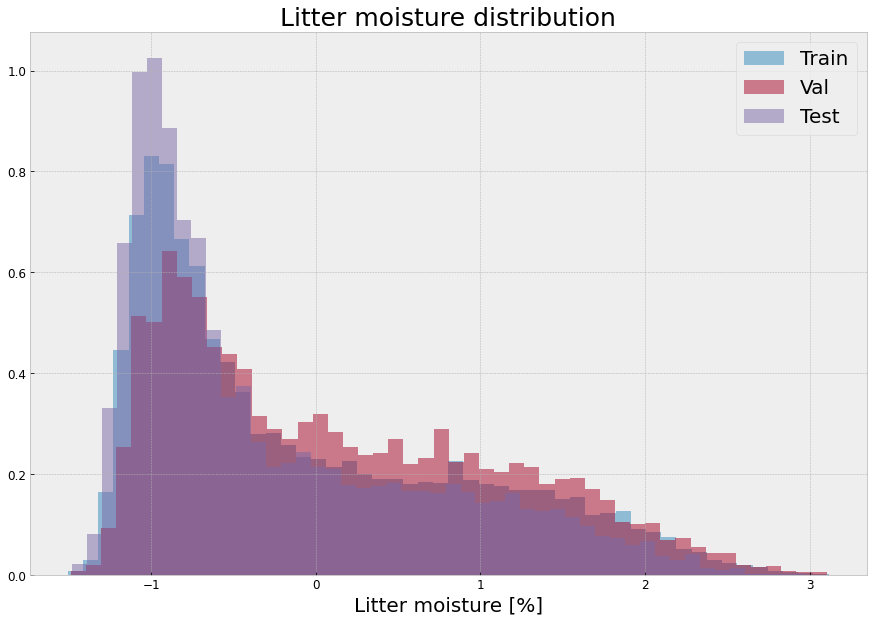

In [7]:
fig, ax = plt.subplots()


ax.hist(train_y, bins=50, density=True, label="Train", alpha=0.5)
ax.hist(val_y, bins=50, density=True, label="Val", alpha=0.5)
ax.hist(test_y, bins=50, density=True, label="Test", alpha=0.5)

plt.title("Litter moisture distribution", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Litter moisture [%]", fontsize=20)
plt.legend(fontsize=20)

plt.savefig("litter_moisture_norm.svg")

In [8]:
if SCALING == "normalization":
    train_y = (
        (wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]) * train_y
    ) + wg.train_min["litter_moisture"]
    val_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_y + wg.train_min["litter_moisture"]
    test_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_y + wg.train_min["litter_moisture"]

    y_morning_train = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * train_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_val = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_test = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_x[0][:, 0] + wg.train_min["litter_moisture"]

elif SCALING == "standarization":
    train_y = (
        train_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    )
    val_y = val_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    test_y = test_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]

    y_morning_train = (
        train_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_val = (
        val_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_test = (
        test_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )

else:
    y_morning_train = train_x[0][:, 0]
    y_morning_val = val_x[0][:, 0]
    y_morning_test = test_x[0][:, 0]

pct_change_train = (train_y - y_morning_train) / y_morning_train * 100
pct_change_val = (val_y - y_morning_val) / y_morning_val * 100
pct_change_test = (test_y - y_morning_test) / y_morning_test * 100

pct_change_mean = pct_change_train.mean()
pct_change_std = pct_change_train.std()

pct_change_standarized_train = (pct_change_train - pct_change_mean) / pct_change_std
pct_change_standarized_val = (pct_change_val - pct_change_mean) / pct_change_std
pct_change_standarized_test = (pct_change_test - pct_change_mean) / pct_change_std

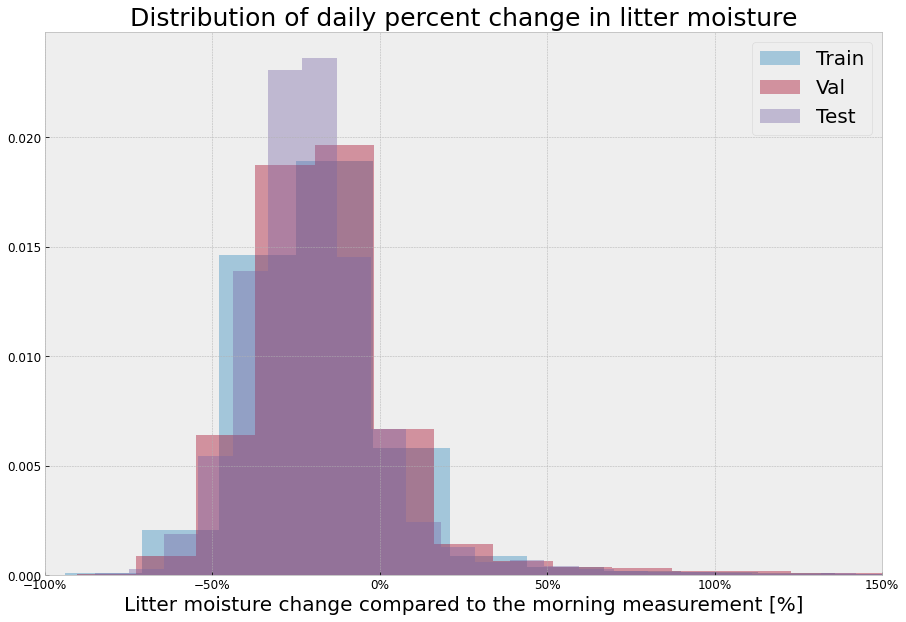

In [9]:
fig, ax = plt.subplots()


ax.hist(pct_change_train, bins=50, density=True, label="Train", alpha=0.4)
ax.hist(pct_change_val, bins=50, density=True, label="Val", alpha=0.4)
ax.hist(pct_change_test, bins=50, density=True, label="Test", alpha=0.4)

plt.xlim([-100, 150])
plt.title("Distribution of daily percent change in litter moisture", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.set_xlabel(
    "Litter moisture change compared to the morning measurement [%]", fontsize=20
)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_change.svg")

In [6]:
train_x = np.concatenate([x.reshape((x.shape[0], -1)) for x in train_x], axis=1)
val_x = np.concatenate([x.reshape((x.shape[0], -1)) for x in val_x], axis=1)
test_x = np.concatenate([x.reshape((x.shape[0], -1)) for x in test_x], axis=1)


def get_dense_model():

    if OTHER_SEQ_LEN:
        input_n = sum(OTHER_SEQ_LEN)
    else:
        input_n = BASE_SEQ_LEN * len(INTERVALS)
    input_n *= len(FEATURES)
    input_n += 1 if USE_PREVIOUS_Y else 0
    input_n += 2 if INCLUDE_COORDS else 0
    inputs = tf.keras.layers.Input(shape=(input_n), name="dense_input")

    dense1 = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
    dropout1 = tf.keras.layers.Dropout(0.2, name="dropout_1")(dense1)
    dense2 = tf.keras.layers.Dense(16, activation="relu", name="dense_2")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.2, name="dropout_2")(dense2)

    outputs = tf.keras.layers.Dense(1, name="output")(dropout2)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
model = get_dense_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 2523)]            0         
                                                                 
 dense_1 (Dense)             (None, 64)                161536    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 162,593
Trainable params: 162,593
Non-trainable

In [ ]:
tf.keras.utils.plot_model(
    model,
    "model.png",
    show_shapes=True,
    show_dtype=True,
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss=tf.keras.losses.Huber(0.65),
)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
    x=train_x,
    y=pct_change_standarized_train,
    epochs=500,
    validation_data=(val_x, pct_change_standarized_val),
    callbacks=[es],
)

In [ ]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

In [ ]:
delta = test_predictions - pct_change_standarized_test
print(delta.std())
_ = plt.hist(delta, bins=100)

In [ ]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

In [ ]:
# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Dense model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.05)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=100, density=True)
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)

error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=25, density=True)
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)

plt.savefig("results_error_show_conv2.svg")

In [ ]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(y_real, y_pred, c=z, s=100, alpha=0.5)
ax_hist_x.hist(y_real, orientation="horizontal", bins=50, density=True)
ax_hist_y.hist(y_pred, bins=50, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_xlabel("Real", fontsize=20)
ax_scatter.set_ylabel("Predicted", fontsize=20)
plt.show()

plt.savefig("results_boundary_distribution.svg")

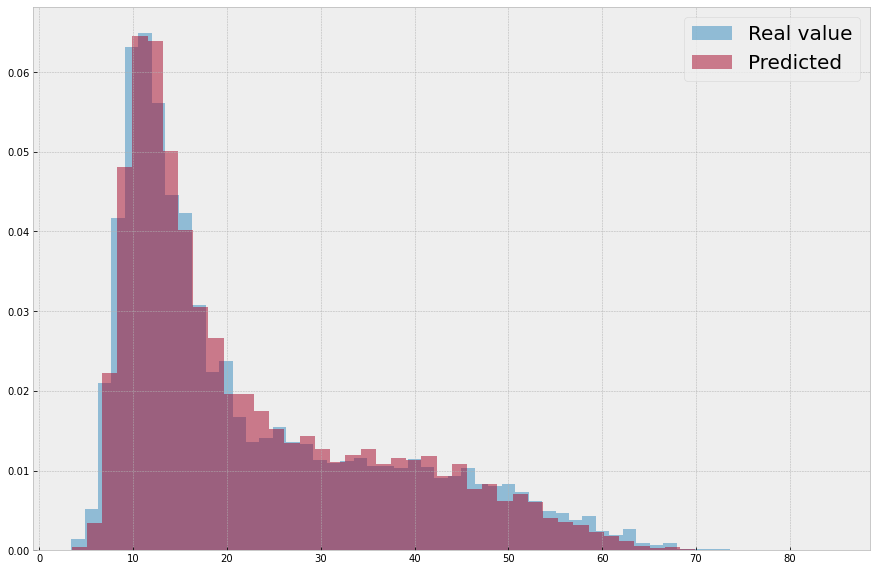

In [ ]:
_ = plt.hist(y_real, bins=50, density=True, alpha=0.5, label="Real value")
_ = plt.hist(y_pred, bins=50, density=True, alpha=0.5, label="Predicted")
plt.legend(fontsize=20)

plt.savefig("results_distribution_conv.svg")

In [ ]:
tf.keras.models.save_model(model, "best_custom_dense_pct_std")